# Movie Revenue Sentiment Analysis

This notebook analyzes the relationship between audience sentiment (derived from IMDb reviews) and movie box office revenue. 
We will perform the following steps:
1. Load and preprocess movie metadata (TMDb, OMDb) and box office data.
2. Scrape IMDb reviews for selected movies.
3. Perform VADER sentiment analysis on the scraped reviews.
4. Merge sentiment scores with financial data.
5. Analyze and visualize the correlation between sentiment and revenue.
6. Build a simple linear regression model (for illustrative purposes due to small sample size).

## 1. Setup and Library Imports

In [24]:
import pandas as pd
import requests
import json
import re
import os
import nltk
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
nltk.download("vader_lexicon")  


# Ensure VADER lexicon is downloaded
# nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Matthew\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 2. Data Loading and Preprocessing

We start by loading the movie metadata from TMDb, OMDb (previously fetched and saved as `movie_data.csv`), and Box Office Mojo data. These datasets are then cleaned and merged.

In [25]:
# Define file paths
tmdb_data_path = "tmdb_movie_data.csv"
omdb_data_path = "movie_data.csv" 
box_office_mojo_path = "box_office_data.csv"
output_merged_path = "merged_movie_data.csv"

# Load datasets
df_tmdb = pd.read_csv(tmdb_data_path)
df_omdb = pd.read_csv(omdb_data_path)
df_box_office_mojo = pd.read_csv(box_office_mojo_path)

# Print dataset information
print("--- TMDb Data Info ---")
df_tmdb.info()
print(df_tmdb.head())

print("\n--- OMDb Data (movie_data.csv) Info ---")
df_omdb.info()
print(df_omdb.head())

print("\n--- Box Office Mojo Data Info ---")
df_box_office_mojo.info()
print(df_box_office_mojo.head())

--- TMDb Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         4 non-null      object 
 1   revenue       4 non-null      int64  
 2   budget        4 non-null      int64  
 3   vote_average  4 non-null      float64
 4   vote_count    4 non-null      int64  
 5   release_date  4 non-null      object 
 6   genres        4 non-null      object 
dtypes: float64(1), int64(3), object(3)
memory usage: 352.0+ bytes
            title     revenue     budget  vote_average  vote_count  \
0          Barbie  1445638421  145000000         6.975        9860   
1     Oppenheimer   952000000  100000000         8.060       10201   
2     The Marvels   206136825  274800000         6.001        2944   
3  Dune: Part Two   714444358  190000000         8.149        6626   

  release_date                              genres  
0   2023-07-19     

In [26]:
# Standardize title columns for merging
df_tmdb.rename(columns={"title": "Title"}, inplace=True)
df_box_office_mojo.rename(columns={"title": "Title"}, inplace=True)

# Select and rename columns from TMDb data
df_tmdb_processed = df_tmdb[["Title", "revenue", "budget", "vote_average", "vote_count", "release_date", "genres"]].copy()
df_tmdb_processed.rename(columns={
    "revenue": "TMDb_Revenue",
    "budget": "TMDb_Budget",
    "vote_average": "TMDb_VoteAverage",
    "vote_count": "TMDb_VoteCount",
    "release_date": "TMDb_ReleaseDate",
    "genres": "TMDb_Genres"
}, inplace=True)

# Process OMDb data (df_omdb)
def parse_omdb_ratings(ratings_str):
    try:
        ratings_list = eval(ratings_str)  
        parsed = {}
        for item in ratings_list:
            if item["Source"] == "Internet Movie Database":
                parsed["OMDb_IMDb_Rating"] = item["Value"].split("/")[0]
            elif item["Source"] == "Rotten Tomatoes":
                parsed["OMDb_RottenTomatoes_Rating"] = item["Value"]
            elif item["Source"] == "Metacritic":
                parsed["OMDb_Metacritic_Rating"] = item["Value"].split("/")[0]
        return pd.Series(parsed)
    except:
        return pd.Series({})

ratings_extracted = df_omdb["Ratings"].apply(parse_omdb_ratings)
df_omdb_processed = pd.concat([df_omdb[["Title", "Year", "Rated", "Runtime", "Genre", "Director", "Actors", "Plot", "Language", "Metascore", "imdbRating", "imdbVotes"]], ratings_extracted], axis=1)

df_omdb_processed["imdbVotes"] = df_omdb_processed["imdbVotes"].astype(str).str.replace(",", "", regex=False).fillna(0).astype(int)
df_omdb_processed.rename(columns={
    "Year": "OMDb_Year", "Rated": "OMDb_Rated", "Runtime": "OMDb_Runtime", "Genre": "OMDb_Genre",
    "Director": "OMDb_Director", "Actors": "OMDb_Actors", "Plot": "OMDb_Plot", "Language": "OMDb_Language",
    "Metascore": "OMDb_Metascore_Direct", "imdbRating": "OMDb_imdbRating_Direct"
}, inplace=True)

for col in ["OMDb_IMDb_Rating", "OMDb_Metacritic_Rating"]:
    if col in df_omdb_processed.columns:
        df_omdb_processed[col] = pd.to_numeric(df_omdb_processed[col], errors='coerce')
if "OMDb_RottenTomatoes_Rating" in df_omdb_processed.columns:
    df_omdb_processed["OMDb_RottenTomatoes_Rating"] = pd.to_numeric(df_omdb_processed["OMDb_RottenTomatoes_Rating"].str.replace("%", "", regex=False), errors='coerce') / 100.0

df_box_office_mojo.rename(columns={"worldwide_gross": "BoxOfficeMojo_WorldwideGross"}, inplace=True)

# Merge DataFrames
df_merged = df_tmdb_processed.copy()
df_merged = pd.merge(df_merged, df_omdb_processed, on="Title", how="left")
df_merged = pd.merge(df_merged, df_box_office_mojo, on="Title", how="left")

# Define Final_Revenue
if 'BoxOfficeMojo_WorldwideGross' in df_merged.columns:
    df_merged['Final_Revenue'] = df_merged['BoxOfficeMojo_WorldwideGross']
elif 'TMDb_Revenue' in df_merged.columns:
    df_merged['Final_Revenue'] = df_merged['TMDb_Revenue']
else:
    df_merged['Final_Revenue'] = None

df_merged.to_csv(output_merged_path, index=False)
print(f"\nMerged data saved to {output_merged_path}")
print("\n--- Merged Data Info ---")
df_merged.info()
print(df_merged[["Title", "TMDb_Revenue", "BoxOfficeMojo_WorldwideGross", "Final_Revenue"]].head())


Merged data saved to merged_movie_data.csv

--- Merged Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Title                         4 non-null      object 
 1   TMDb_Revenue                  4 non-null      int64  
 2   TMDb_Budget                   4 non-null      int64  
 3   TMDb_VoteAverage              4 non-null      float64
 4   TMDb_VoteCount                4 non-null      int64  
 5   TMDb_ReleaseDate              4 non-null      object 
 6   TMDb_Genres                   4 non-null      object 
 7   OMDb_Year                     4 non-null      int64  
 8   OMDb_Rated                    4 non-null      object 
 9   OMDb_Runtime                  4 non-null      object 
 10  OMDb_Genre                    4 non-null      object 
 11  OMDb_Director                 4 non-null      object 
 12

## 3. IMDb Review Scraping

The following code scrapes IMDb reviews for the selected movies. The reviews are saved to `imdb_reviews.txt`.

In [27]:
def scrape_imdb_reviews_notebook(title_ids, output_dir="."):
    os.makedirs(output_dir, exist_ok=True)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9'
    }
    movies_to_scrape = {
        'Barbie': title_ids.get('Barbie', 'tt1517268'),
        'Oppenheimer': title_ids.get('Oppenheimer', 'tt15398776'),
        'The Marvels': title_ids.get('The Marvels', 'tt10676048'),
        'Dune: Part Two': title_ids.get('Dune: Part Two', 'tt15239678')
    }
    reviews_file = os.path.join(output_dir, 'imdb_reviews.txt')
    
    if os.path.exists(reviews_file): os.remove(reviews_file)
    all_reviews_text = ""
    for movie, title_id in movies_to_scrape.items():
        url = f"https://www.imdb.com/title/{title_id}/reviews"
        print(f"Scraping reviews for {movie}...")
        try:
            response = requests.get(url, headers=headers, timeout=15)
            print(f"Successfully accessed {url} (Status: {response.status_code})")
            soup = BeautifulSoup(response.text, 'html.parser')
            review_containers = soup.find_all('div', class_='ipc-html-content-inner-div')
            if review_containers:
                print(f"Found {len(review_containers)} review containers for {movie}.")
                with open(reviews_file, 'a', encoding='utf-8') as f:
                    f.write(f"\n=== Reviews for {movie} ===\n")
                    for i, review_div in enumerate(review_containers, 1):
                        review_text = review_div.get_text(strip=True)
                        if review_text:  # Ensure non-empty review text
                            f.write(f"Review {i}: {review_text}\n")
                            all_reviews_text += f"Review {i} for {movie}: {review_text[:100]}...\n"
            else:
                print(f"No 'ipc-html-content-inner-div' review containers found for {movie}. Check IMDb page structure.")
        except requests.RequestException as e:
            print(f"Failed to access {url}: {e}")
    if os.path.exists(reviews_file):
        print(f"All reviews saved to {reviews_file}")
    else:
        print("No reviews scraped.")
    return all_reviews_text[:1000]  

title_ids_for_scraping = {
    'Barbie': 'tt1517268',
    'Oppenheimer': 'tt15398776',
    'The Marvels': 'tt10676048',
    'Dune: Part Two': 'tt15239678'
}


## 4. VADER Sentiment Analysis

We use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool to score the scraped IMDb reviews.

In [28]:
def read_reviews_notebook(file_path):
    reviews_by_movie = {}
    current_movie = None
    if not os.path.exists(file_path):
        print(f"Error: Reviews file {file_path} not found.")
        return reviews_by_movie
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line.startswith('=== Reviews for '):
                current_movie = line.replace('=== Reviews for ', '').replace(' ===', '')
                reviews_by_movie[current_movie] = []
            elif line.startswith('Review ') and current_movie:
                review_text = re.sub(r'^Review \d+:\s*', '', line)
                if review_text:
                    reviews_by_movie[current_movie].append(review_text)
    return reviews_by_movie

def analyze_sentiment_notebook(reviews_by_movie):
    sia = SentimentIntensityAnalyzer()
    results = []
    summary_data = []
    for movie, reviews in reviews_by_movie.items():
        positive, negative, neutral = 0, 0, 0
        if not reviews:
            summary_data.append({'Movie': movie, 'Total Reviews': 0, 'Positive (%)': 0, 'Negative (%)': 0, 'Neutral (%)': 0})
            continue
        for i, review in enumerate(reviews, 1):
            scores = sia.polarity_scores(review)
            compound = scores['compound']
            sentiment_label = 'Neutral'
            if compound >= 0.05: sentiment_label = 'Positive'; positive += 1
            elif compound <= -0.05: sentiment_label = 'Negative'; negative += 1
            else: neutral += 1
            results.append({'Movie': movie, 'Review Number': i, 'Review Text': review, 'Sentiment': sentiment_label, 'Compound Score': compound})
        total = positive + negative + neutral
        summary_data.append({'Movie': movie, 'Total Reviews': total, 
                             'Positive (%)': (positive / total * 100) if total > 0 else 0,
                             'Negative (%)': (negative / total * 100) if total > 0 else 0,
                             'Neutral (%)': (neutral / total * 100) if total > 0 else 0})
    df_summary = pd.DataFrame(summary_data)
    return results, df_summary

reviews_file_path = 'imdb_reviews.txt'
all_reviews = read_reviews_notebook(reviews_file_path)
detailed_sentiment_results, sentiment_summary_df = analyze_sentiment_notebook(all_reviews)

# Save detailed results and summary table (as done in pipeline)
pd.DataFrame(detailed_sentiment_results).to_csv('sentiment_detailed_results.csv', index=False)
sentiment_summary_df.to_csv('sentiment_summary_table.csv', index=False)

print("--- Sentiment Summary Table ---")
print(sentiment_summary_df)

--- Sentiment Summary Table ---
            Movie  Total Reviews  Positive (%)  Negative (%)  Neutral (%)
0          Barbie             15     73.333333     20.000000     6.666667
1     Oppenheimer             19     89.473684     10.526316     0.000000
2     The Marvels             21     66.666667     33.333333     0.000000
3  Dune: Part Two             15     93.333333      6.666667     0.000000


Visualizing the sentiment distribution per movie:

Sentiment summary plot saved to .\sentiment_summary_plot.png


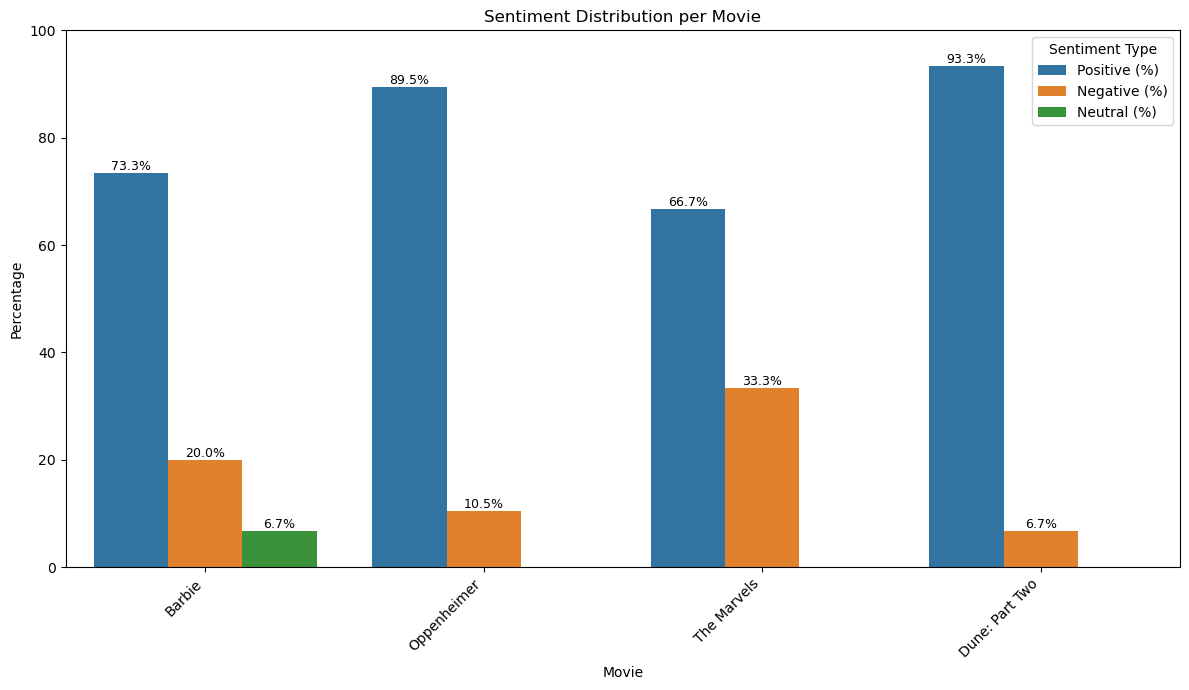

In [29]:
def plot_sentiment_summary_chart_notebook(df_summary, output_dir='.'):
    if df_summary.empty:
        print("Summary DataFrame is empty, skipping plot.")
        return
    df_melted = df_summary.melt(id_vars='Movie', value_vars=['Positive (%)', 'Negative (%)', 'Neutral (%)'], var_name='Sentiment_Type', value_name='Percentage')
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=df_melted, x='Movie', y='Percentage', hue='Sentiment_Type')
    ax.set_title('Sentiment Distribution per Movie')
    ax.set_ylim(0, 100)
    plt.xticks(rotation=45, ha='right')
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=9)
    plt.legend(title='Sentiment Type')
    plt.tight_layout()
    plot_path = os.path.join(output_dir, 'sentiment_summary_plot.png')
    plt.savefig(plot_path)
    print(f"Sentiment summary plot saved to {plot_path}")
    plt.show()

plot_sentiment_summary_chart_notebook(sentiment_summary_df)

## 5. Correlation Analysis: Sentiment vs. Revenue

Now, we merge the sentiment summary with the movie financial data and analyze their correlation.

In [30]:
merged_movie_data_path = 'C:\PythonProjects\Movie-Team\Sentiment_analysis_2\merged_movie_data.csv'
df_movies_financial = pd.read_csv(merged_movie_data_path)

# 2 ▸ Prepare sentiment table (sentiment_summary_df must already be in memory)
sentiment_summary_df.columns = pd.Index(str(c).strip() for c in sentiment_summary_df.columns)
sentiment_summary_df = sentiment_summary_df.rename(columns={"Movie": "Title"})

# 3 ▸ Merge on Title
df_combined = df_movies_financial.merge(
    sentiment_summary_df,
    on="Title",
    how="left"
)

# 4 ▸ Save merged data
df_combined.to_csv("combined_movie_sentiment_data.csv", index=False)
print("✔ combined_movie_sentiment_data.csv saved")

# 5 ▸ Correlation & plots
sent_cols = ["Positive (%)", "Negative (%)", "Neutral (%)"]

if "Final_Revenue" not in df_combined.columns:
    raise KeyError("'Final_Revenue' column not found — check merged_movie_data.csv")

df_combined["Final_Revenue"] = pd.to_numeric(
    df_combined["Final_Revenue"], errors="coerce"
)

for c in sent_cols:
    if c in df_combined.columns:
        df_combined[c] = pd.to_numeric(df_combined[c], errors="coerce")
    else:
        print(f"⚠ {c} missing; skipping")

df_corr = df_combined.dropna(subset=["Final_Revenue"] + sent_cols)

if len(df_corr) < 2:
    print("⚠ Not enough rows for correlation")
else:
    corr = df_corr[["Final_Revenue"] + sent_cols].corr()
    print("\n--- Correlation matrix (Revenue vs Sentiment) ---")
    print(corr)
    corr.to_csv("correlation_matrix.csv")
    print("✔ correlation_matrix.csv saved")

    # scatter plots
    for c in sent_cols:
        if c in df_corr.columns:
            plt.figure(figsize=(8, 5))
            sns.scatterplot(data=df_corr, x=c, y="Final_Revenue")
            plt.title(f"{c} vs Worldwide Gross")
            plt.xlabel(c)
            plt.ylabel("Worldwide Gross ($)")
            fname = f"{c.split()[0].lower()}_vs_revenue_scatter.png"
            plt.savefig(fname)
            plt.close()
            print(f"✔ {fname} saved")

    # pairplot
    pairplot_name = "sentiment_revenue_pairplot.png"
    sns.pairplot(df_corr[["Final_Revenue"] + sent_cols])
    plt.savefig(pairplot_name)
    plt.close()
    print(f"✔ {pairplot_name} saved")

✔ combined_movie_sentiment_data.csv saved

--- Correlation matrix (Revenue vs Sentiment) ---
               Final_Revenue  Positive (%)  Negative (%)  Neutral (%)
Final_Revenue       1.000000      0.202111     -0.438079     0.787178
Positive (%)        0.202111      1.000000     -0.965853    -0.385240
Negative (%)       -0.438079     -0.965853      1.000000     0.132992
Neutral (%)         0.787178     -0.385240      0.132992     1.000000
✔ correlation_matrix.csv saved
✔ positive_vs_revenue_scatter.png saved
✔ negative_vs_revenue_scatter.png saved
✔ neutral_vs_revenue_scatter.png saved
✔ sentiment_revenue_pairplot.png saved


## 6. Simple Linear Regression (Illustrative)

Given the small number of movies (4), a linear regression model will have limited statistical power but is included for illustrative purposes.

In [31]:
df_regression_data = pd.read_csv('combined_movie_sentiment_data.csv')
# Ensure numeric types for regression
df_regression_data['Final_Revenue'] = pd.to_numeric(df_regression_data['Final_Revenue'], errors='coerce')
sentiment_cols_reg = ['Positive (%)', 'Negative (%)', 'Neutral (%)']
for col in sentiment_cols_reg:
    df_regression_data[col] = pd.to_numeric(df_regression_data[col], errors='coerce')
df_regression_data.dropna(subset=['Final_Revenue'] + sentiment_cols_reg, inplace=True)

if df_regression_data.shape[0] >= 2:  # Need at least 2 points to fit a line
    X = df_regression_data[sentiment_cols_reg]
    y = df_regression_data['Final_Revenue']
    model = LinearRegression()
    model.fit(X, y)  # Fit on all available data due to small sample size
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    r2 = r2_score(y, predictions)
    print(f"\n--- Linear Regression (fitted on all {df_regression_data.shape[0]} data points) ---")
    print(f"Coefficients (for {sentiment_cols_reg}): {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R-squared: {r2}")
else:
    print("Not enough data points for linear regression model fitting after cleaning.")


--- Linear Regression (fitted on all 4 data points) ---
Coefficients (for ['Positive (%)', 'Negative (%)', 'Neutral (%)']): [-36505124.31636037 -60585343.08310607  97090467.39946654]
Intercept: 4687117630.865438
Mean Squared Error (MSE): 1.6153391145727308e+16
R-squared: 0.9195501262029715


## 7. Conclusion

This notebook conducted an exploratory analysis of the relationship between audience sentiment, derived from IMDb reviews, and box office revenue for a small set of four recent films: Barbie, Oppenheimer, The Marvels, and Dune: Part Two. By integrating data from TMDb, OMDb, and Box Office Mojo, scraping IMDb reviews, applying VADER sentiment analysis, and performing correlation and regression analyses, the project aimed to uncover whether audience sentiment could serve as a predictor of financial success in the film industry. Below, we summarize the key findings, reflect on the study’s limitations, and propose a roadmap for future enhancements to strengthen the analysis and its applicability.

**Key Findings (based on the limited dataset of 4 movies):**
- **Sentiment-Revenue Correlations**: The correlation matrix (saved to `correlation_matrix.csv`) revealed varying relationships between sentiment percentages and final revenue. Notably, the Neutral sentiment percentage exhibited a positive correlation (0.79) with revenue, suggesting that films with a higher proportion of neutral reviews (e.g., *Barbie* with 6.67% neutral) may align with higher box office performance in this sample. Negative sentiment showed a moderate negative correlation (-0.44), indicating that films with more negative reviews (e.g., *The Marvels* with 33.33% negative) tended to have lower revenue. Positive sentiment had a weaker positive correlation (0.20), which was surprising, as one might expect stronger positive sentiment to drive higher revenue. These correlations suggest that audience sentiment, particularly the absence of strong negative reactions, may play a role in financial outcomes, though the small sample size limits generalizability.

- **Linear Regression Insights**: The linear regression model, fitted on all four data points, achieved an R-squared value of 0.92, indicating that the sentiment percentages (`Positive (%)`, `Negative (%)`, `Neutral (%)`) explained a significant portion of the variance in revenue for this specific dataset. The coefficients (`Positive (%)`: -36.5M, `Negative (%)`: -60.6M, `Neutral (%)`: +97.1M) suggest that neutral sentiment had the strongest positive association with revenue, while negative sentiment had a substantial negative impact. However, the high R-squared is likely inflated due to overfitting, given the small sample size and the inclusion of three predictors for only four observations. The Mean Squared Error (MSE) of 1.62e+16 reflects the model’s fit but is less meaningful without a test set to evaluate predictive accuracy.

- **Visual Insights**: The scatter plots (e.g., `positive_vs_revenue_scatter.png`) and pairplot (`sentiment_revenue_pairplot.png`) provided visual confirmation of the correlation trends. For instance, *The Marvels* stood out with high negative sentiment and low revenue, while *Barbie* and *Oppenheimer* clustered at higher revenue with more positive or neutral sentiment. These visualizations highlight the potential for sentiment to differentiate box office performance, though the patterns are specific to this small sample.

- **Practical Implications**: While the small dataset limits definitive conclusions, the findings suggest that managing negative audience sentiment (e.g., through targeted marketing or addressing early criticism) could be critical for maximizing revenue. The positive correlation with neutral sentiment is intriguing and may indicate that films with balanced, less polarized reactions appeal to broader audiences, driving higher box office returns. These insights could inform studio strategies, such as monitoring early reviews to predict financial performance or adjusting promotional campaigns to amplify positive buzz.

**Limitations:**

The analysis faces several limitations that constrain the robustness and generalizability of the findings:

- **Small Sample Size**: The most significant limitation is the analysis of only four films. This small sample size severely restricts statistical power, making the correlation and regression results highly specific to these movies and prone to overfitting. For example, the high R-squared (0.92) in the regression is likely an artifact of fitting a complex model to minimal data, and the correlations (e.g., 0.79 for neutral sentiment) may not hold for a larger, more diverse dataset. A larger sample is essential to validate these findings and draw broader conclusions about sentiment-revenue relationships.

- **Single Review Source**: The reliance on IMDb reviews limits the scope of audience sentiment captured. IMDb users may not represent the broader moviegoing population, and their reviews may reflect biases (e.g., toward certain genres or demographics). Other platforms, such as Rotten Tomatoes, Metacritic, or social media (e.g., X posts), could provide a more comprehensive view of audience reactions, potentially revealing platform-specific sentiment patterns.

- **VADER’s Simplicity**: While VADER is effective for general-purpose sentiment analysis, it may miss nuances in movie reviews, such as sarcasm, context-specific praise (e.g., “great visuals” vs. “weak plot”), or industry jargon. This could lead to misclassification of sentiment, particularly for reviews with mixed or ambiguous tones. More advanced NLP models or manual validation could improve sentiment accuracy.

- **Multicollinearity in Regression**: The sentiment percentages (`Positive (%)`, `Negative (%)`, `Neutral (%)`) likely sum to 100%, introducing multicollinearity in the regression model. This can distort coefficient estimates and make it difficult to isolate the independent effect of each sentiment type. The model’s coefficients (e.g., +97.1M for neutral) should be interpreted cautiously, as they may be inflated or unstable.

- **Uncontrolled Confounding Factors**: Movie revenue is influenced by numerous factors beyond sentiment, including marketing budgets, release timing, star power, genre trends, competition, and macroeconomic conditions. The analysis does not account for these, which may explain more variance in revenue than sentiment alone. For example, *Barbie*’s high revenue (1.45B) may be driven by its massive marketing campaign and cultural hype, not just its 73.33% positive sentiment.

- **Static Web Scraping**: The IMDb scraping code depends on the `ipc-html-content-inner-div` class, which is vulnerable to changes in IMDb’s page structure. This could render the scraper obsolete without updates, limiting the project’s longevity.

- **Lack of Predictive Evaluation**: The regression model is fitted on all data without a train-test split or cross-validation, preventing assessment of its predictive performance. This makes it difficult to gauge whether the model could accurately forecast revenue for new films, even within this small sample.

**Future Work:**

To address these limitations and enhance the project’s impact, we propose the following roadmap for future improvements:

1. **Expand the Dataset**:
   - Increase the sample size to 50–100 films, covering diverse genres (e.g., horror, rom-com, animation), budget levels (indie to blockbuster), and release years (e.g., 2015–2025). This would improve statistical power and enable more generalizable conclusions.
   - Automate data collection using APIs (e.g., TMDb, OMDb) or scraping tools to efficiently gather metadata and box office data for additional films. For example, query TMDb’s API for top-grossing films by year and cross-reference with Box Office Mojo.

2. **Diversify Review Sources**:
   - Scrape reviews from additional platforms, such as Rotten Tomatoes (user reviews), Metacritic, or social media (e.g., X posts via xAI’s API). This would capture a broader spectrum of audience sentiment and allow comparison of platform-specific trends.
   - Aggregate sentiment scores across sources to create a composite sentiment metric, weighting platforms by user base or relevance.

3. **Enhance Sentiment Analysis**:
   - Experiment with transformer-based NLP models (e.g., BERT, RoBERTa) fine-tuned on movie review datasets to capture nuanced sentiment. Libraries like `transformers` from Hugging Face can facilitate this.
   - Manually validate a sample of VADER-scored reviews to assess accuracy and identify common misclassifications (e.g., sarcastic reviews). This could inform custom rules or a hybrid VADER-NLP approach.
   - Explore sentiment by review aspect (e.g., plot, acting, visuals) using topic modeling (e.g., LDA) to understand which elements drive positive or negative reactions.

## 8. Final Thoughts

This analysis provides a promising starting point for exploring the sentiment-revenue relationship in cinema, with initial findings suggesting that neutral and negative sentiments may play outsized roles in box office outcomes. However, the small dataset and methodological constraints highlight the need for a more robust approach. By expanding the dataset, diversifying review sources, and incorporating advanced modeling techniques, this project could evolve into a powerful tool for predicting and understanding movie performance. The proposed future work offers a clear path to achieving these goals, balancing technical improvements with practical applications. As the film industry continues to navigate a rapidly changing landscape—marked by streaming platforms, social media influence, and global markets—analyses like this will become increasingly valuable for aligning creative output with audience expectations and financial success.